In [2]:
# =============================================================================
# Demand Planning Forecasting (Statistical Methods) in Python
# =============================================================================
# Purpose:
#   - Create synthetic demand time series data (with trend + seasonality + noise)
#   - Implement classic statistical forecasting methods in plain Python (NumPy)
#   - Visualize forecasts and compare methods using common demand-planning KPIs
#
# Methods included:
#   1) Naive (Last Value)
#   2) Seasonal Naive (Last Season)
#   3) Moving Average
#   4) Simple Exponential Smoothing (SES)
#   5) Holt’s Linear Trend (Double Exponential Smoothing)
#
# Notes:
#   - This is intentionally "from scratch" (NumPy + Matplotlib) for transparency.
#   - In production, you'd typically use statsmodels / pmdarima, but implementing
#     manually is great for GitHub portfolio value and method understanding.
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# =============================================================================
# 0) Config
# =============================================================================
SEED = 42
N_PERIODS = 156               # e.g., weekly demand for 3 years (52*3)
SEASON_LENGTH = 52            # weekly seasonality
TRAIN_RATIO = 0.80            # train/test split
EPS = 1e-9                    # numerical safety

np.random.seed(SEED)

In [4]:
# =============================================================================
# 1) Create Synthetic Demand Data (NumPy)
# =============================================================================
# We simulate a demand signal with:
#   - baseline level
#   - upward trend
#   - seasonal component (sinusoidal)
#   - random noise
#   - occasional promo spikes (optional realism)
#
# This mimics a typical SKU-level demand pattern: not purely random, has structure.

t = np.arange(N_PERIODS)

baseline = 120.0
trend = 0.35 * t  # mild linear growth
seasonality = 18.0 * np.sin(2 * np.pi * t / SEASON_LENGTH) + 6.0 * np.sin(4 * np.pi * t / SEASON_LENGTH)
noise = np.random.normal(loc=0.0, scale=10.0, size=N_PERIODS)

# Promo spikes: rare positive shocks
promo = np.zeros(N_PERIODS)
promo_weeks = np.random.choice(np.arange(N_PERIODS), size=int(0.06 * N_PERIODS), replace=False)
promo[promo_weeks] = np.random.uniform(15, 45, size=len(promo_weeks))

demand = baseline + trend + seasonality + noise + promo

# Demand planning often assumes non-negative demand
demand = np.maximum(demand, 0.0)

In [5]:
# =============================================================================
# 2) Train/Test Split
# =============================================================================
split_idx = int(N_PERIODS * TRAIN_RATIO)
y_train = demand[:split_idx]
y_test = demand[split_idx:]

# We'll forecast len(y_test) steps ahead.
H = len(y_test)

In [6]:
# =============================================================================
# 3) Forecasting Methods (from scratch)
# =============================================================================

def forecast_naive(y_train: np.ndarray, horizon: int) -> np.ndarray:
    """
    Naive Forecast (Last Observation Carried Forward).
    - Forecast for all future periods equals the last observed demand.
    Pros:
      - Very strong baseline, surprisingly hard to beat for noisy series
      - No parameters, fast, stable
    Cons:
      - Ignores trend and seasonality
      - Can lag badly when demand is changing
    """
    last = y_train[-1]
    return np.full(horizon, last, dtype=float)


def forecast_seasonal_naive(y_train: np.ndarray, horizon: int, season_length: int) -> np.ndarray:
    """
    Seasonal Naive Forecast.
    - Forecast repeats the value from the same season last cycle (e.g., same week last year).
    Pros:
      - Captures seasonality with zero optimization
      - Strong baseline for seasonal SKUs
    Cons:
      - Cannot model trend (will under/over forecast if level is shifting)
      - Needs at least one full season of history
    """
    if len(y_train) < season_length:
        # Fallback: if not enough history, use non-seasonal naive
        return forecast_naive(y_train, horizon)

    # Repeat last season pattern forward
    last_season = y_train[-season_length:]
    reps = int(np.ceil(horizon / season_length))
    f = np.tile(last_season, reps)[:horizon]
    return f.astype(float)


def forecast_moving_average(y_train: np.ndarray, horizon: int, window: int = 8) -> np.ndarray:
    """
    Moving Average Forecast.
    - Forecast equals the average of the last 'window' observations.
    Pros:
      - Smooths noise (useful when demand is stable)
      - Simple and interpretable
    Cons:
      - Lags trend and seasonality
      - Window choice matters (too small = noisy, too big = sluggish)
    """
    w = min(window, len(y_train))
    avg = float(np.mean(y_train[-w:]))
    return np.full(horizon, avg, dtype=float)


def forecast_ses(y_train: np.ndarray, horizon: int, alpha: float = 0.25) -> np.ndarray:
    """
    Simple Exponential Smoothing (SES).
    Level update: L_t = alpha * y_t + (1 - alpha) * L_{t-1}
    Forecast: F_{t+h} = L_t (constant for all h)

    Pros:
      - Better than moving average at weighting recent data more
      - One parameter, stable, widely used for short-term planning
    Cons:
      - No explicit trend or seasonality; can lag if demand shifts
      - alpha must be tuned (too high = jittery, too low = slow)
    """
    # Initialize level with first observation (common simple initialization)
    level = y_train[0]
    for yt in y_train[1:]:
        level = alpha * yt + (1 - alpha) * level
    return np.full(horizon, level, dtype=float)


def forecast_holt_linear(y_train: np.ndarray, horizon: int, alpha: float = 0.25, beta: float = 0.10) -> np.ndarray:
    """
    Holt's Linear Trend Method (Double Exponential Smoothing).
    Level: L_t = alpha*y_t + (1-alpha)*(L_{t-1} + T_{t-1})
    Trend: T_t = beta*(L_t - L_{t-1}) + (1-beta)*T_{t-1}
    Forecast: F_{t+h} = L_t + h*T_t

    Pros:
      - Captures trend explicitly (common in demand planning for growing/declining SKUs)
      - Still relatively simple (two parameters)
    Cons:
      - No seasonality (Holt-Winters adds it, but is more complex)
      - Sensitive to outliers/promo spikes unless treated
      - alpha/beta tuning matters
    """
    # Simple initialization:
    level = y_train[0]
    trend = y_train[1] - y_train[0] if len(y_train) > 1 else 0.0

    for yt in y_train[1:]:
        prev_level = level
        level = alpha * yt + (1 - alpha) * (level + trend)
        trend = beta * (level - prev_level) + (1 - beta) * trend

    h = np.arange(1, horizon + 1, dtype=float)
    return (level + h * trend).astype(float)


In [7]:
# =============================================================================
# 4) Evaluation Metrics (Demand Planning KPIs)
# =============================================================================
def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Mean Absolute Percentage Error.
    Warning:
      - Unstable when y_true contains zeros or near-zeros.
      - Common in business, but use carefully with intermittent/low demand.
    """
    denom = np.maximum(np.abs(y_true), EPS)
    return float(np.mean(np.abs(y_true - y_pred) / denom) * 100.0)


def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Symmetric MAPE (sMAPE).
    Often more stable than MAPE for low-demand items.
    """
    denom = np.maximum((np.abs(y_true) + np.abs(y_pred)) / 2.0, EPS)
    return float(np.mean(np.abs(y_true - y_pred) / denom) * 100.0)


def bias_pct(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Forecast Bias as percentage of actual volume.
    Positive bias => over-forecasting; negative => under-forecasting.
    """
    denom = np.maximum(np.sum(y_true), EPS)
    return float((np.sum(y_pred - y_true) / denom) * 100.0)


def rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Root Mean Squared Error (scale-dependent)."""
    return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))


In [8]:
# =============================================================================
# 5) Run Forecasts
# =============================================================================
pred_naive = forecast_naive(y_train, H)
pred_snaive = forecast_seasonal_naive(y_train, H, SEASON_LENGTH)
pred_ma = forecast_moving_average(y_train, H, window=8)
pred_ses = forecast_ses(y_train, H, alpha=0.25)
pred_holt = forecast_holt_linear(y_train, H, alpha=0.25, beta=0.10)

# Collect for evaluation/plotting
models = {
    "Naive": pred_naive,
    "Seasonal Naive": pred_snaive,
    "Moving Avg (8)": pred_ma,
    "SES (a=0.25)": pred_ses,
    "Holt (a=0.25,b=0.10)": pred_holt,
}

In [9]:
# =============================================================================
# 6) Print Comparison Table (console-friendly)
# =============================================================================
print("\n================ Forecast Method Comparison (Test Set) ================")
print(f"{'Method':<20} {'sMAPE%':>10} {'MAPE%':>10} {'Bias%':>10} {'RMSE':>10}")
print("-" * 66)

for name, pred in models.items():
    print(
        f"{name:<20} "
        f"{smape(y_test, pred):>10.2f} "
        f"{mape(y_test, pred):>10.2f} "
        f"{bias_pct(y_test, pred):>10.2f} "
        f"{rmse(y_test, pred):>10.2f}"
    )



================ Forecast Method Comparison (Test Set) ================
Method                   sMAPE%      MAPE%      Bias%       RMSE
------------------------------------------------------------------
Naive                      5.60       5.52      -1.99      12.09
Seasonal Naive            13.34      12.31     -12.30      22.57
Moving Avg (8)            11.75      12.73      11.75      22.09
SES (a=0.25)               9.90      10.61       9.21      18.77
Holt (a=0.25,b=0.10)      15.51      17.15      16.16      28.85


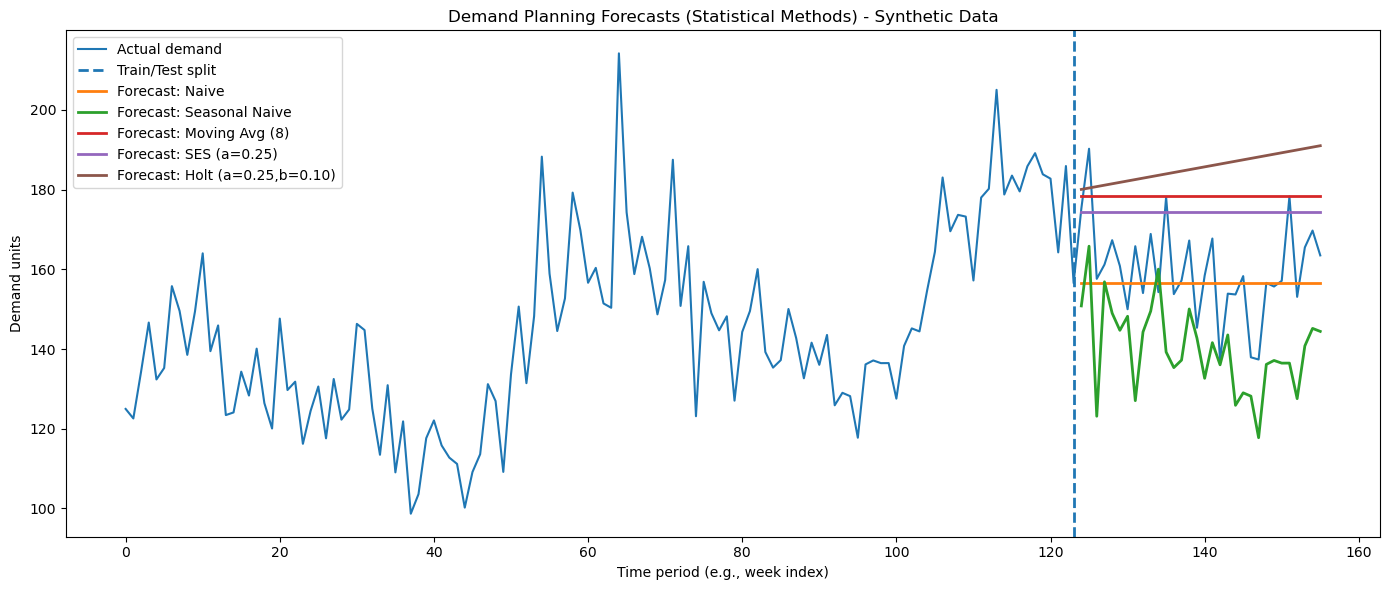

In [10]:
# =============================================================================
# 7) Visualization
# =============================================================================
# Visualization goals (typical for demand planning stakeholders):
#   - Show full historical demand
#   - Show train/test split
#   - Compare multiple forecast methods on the test horizon
#   - Make it obvious which methods lag trend/seasonality

x_all = np.arange(N_PERIODS)
x_train = np.arange(split_idx)
x_test = np.arange(split_idx, N_PERIODS)

plt.figure(figsize=(14, 6))
plt.plot(x_all, demand, label="Actual demand")
plt.axvline(split_idx - 1, linestyle="--", linewidth=2, label="Train/Test split")

# Plot forecasts on test horizon
for name, pred in models.items():
    plt.plot(x_test, pred, linewidth=2, label=f"Forecast: {name}")

plt.title("Demand Planning Forecasts (Statistical Methods) - Synthetic Data")
plt.xlabel("Time period (e.g., week index)")
plt.ylabel("Demand units")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# =============================================================================
# 8) Recommendations: When to Use Which Method (Demand Planning Guidance)
# =============================================================================
# Below is practical method selection guidance you can paste into your README
# and also keep as a "business logic" section inside the code.
#
# ---------------------------------------------------------------------------
# A) Naive (Last Value)
# ---------------------------------------------------------------------------
# Use when:
#   - Demand is very noisy and shows no stable seasonality or trend
#   - You need a strong baseline to benchmark more complex models
#   - Short horizons where last observed value is often a reasonable anchor
# Good because:
#   - Zero parameters, impossible to overfit
#   - Often competitive for volatile SKUs
# Bad because:
#   - Fails under trend changes (growth/decline) and seasonal patterns
#   - Will lag shifts (e.g., new pricing, new customer, distribution change)
#
# Typical demand planning fit:
#   - New SKUs with limited history (as a baseline)
#   - Highly erratic SKUs where complexity adds little value
#
# ---------------------------------------------------------------------------
# B) Seasonal Naive (Last Season)
# ---------------------------------------------------------------------------
# Use when:
#   - Strong, stable seasonality exists (weekly/yearly), and pattern repeats
#   - You have at least 1 full season of history (e.g., 52 weeks)
# Good because:
#   - Very strong baseline for seasonal items with minimal complexity
#   - Easy to explain: "same week as last year"
# Bad because:
#   - Ignores structural trend (will under-forecast if demand is growing)
#   - Breaks when seasonality shifts (new promotions, assortment changes)
#
# Typical demand planning fit:
#   - Seasonal retail items, holiday patterns, weather-driven patterns
#   - Mature SKUs with repeatable yearly seasonality
#
# ---------------------------------------------------------------------------
# C) Moving Average
# ---------------------------------------------------------------------------
# Use when:
#   - Demand is stable (no strong trend/seasonality) and you want smoothing
#   - You want to reduce noise from week-to-week variability
#   - Short horizons; you want "typical recent level"
# Good because:
#   - Intuitive and easy to explain to planners
#   - Smooths random fluctuations
# Bad because:
#   - Lags trend (window creates delay)
#   - Window selection is arbitrary and can be wrong per SKU
#   - Performs poorly with seasonality unless window aligns with season
#
# Typical demand planning fit:
#   - Stable “base demand” items where minor smoothing helps
#   - Quick operational planning for low-volatility SKUs
#
# ---------------------------------------------------------------------------
# D) Simple Exponential Smoothing (SES)
# ---------------------------------------------------------------------------
# Use when:
#   - Demand has a relatively stable level but is noisy
#   - You want a smarter smoother than moving average (more weight on recent)
#   - You want one parameter to tune (alpha)
# Good because:
#   - Adapts faster than moving average (depending on alpha)
#   - Very common in classical planning systems
# Bad because:
#   - No explicit trend or seasonality (can lag systematically)
#   - Sensitive to promo spikes/outliers if alpha is high
#
# Typical demand planning fit:
#   - Short-term planning for stable items
#   - As a component for baseline demand before promo uplift modeling
#
# ---------------------------------------------------------------------------
# E) Holt’s Linear Trend (Double Exponential Smoothing)
# ---------------------------------------------------------------------------
# Use when:
#   - Demand shows a clear upward/downward trend without strong seasonality
#   - You want simple trend handling without complex models
# Good because:
#   - Explicitly models trend and improves over SES for growing/declining SKUs
#   - Still interpretable: level + trend
# Bad because:
#   - No seasonality (needs Holt-Winters for that)
#   - Trend can be distorted by promotions, stockouts, one-off events
#   - Can overshoot if trend is temporary
#
# Typical demand planning fit:
#   - Expanding distribution, ramp-up SKUs, gradual decline SKUs
#   - Medium-term projection where trend matters for inventory positioning
#
# ---------------------------------------------------------------------------
# F) Practical Rules of Thumb (What planners actually do)
# ---------------------------------------------------------------------------
# 1) Always benchmark:
#      - Start with Naive and Seasonal Naive baselines.
#      - If your model can’t beat them on sMAPE and reduce bias, stop.
#
# 2) If seasonality is strong:
#      - Seasonal Naive is often tough to beat.
#      - Next step (v2) is Holt-Winters (trend + seasonality).
#
# 3) If trend is strong:
#      - Holt > SES / Moving Average most of the time.
#
# 4) If demand is low / intermittent (many zeros):
#      - MAPE becomes misleading; prefer sMAPE + volume-weighted metrics.
#      - Consider Croston/SBA in v2 (not included here).
#
# 5) If promotions / events exist:
#      - Any pure time-series smoother can be biased.
#      - Best practice: forecast baseline (SES/Holt) + separate promo uplift.
#
# 6) If stockouts happen:
#      - History is censored (observed demand < true demand).
#      - Clean/adjust data or exclude stockout periods; otherwise bias occurs.
#
# ---------------------------------------------------------------------------

